In [4]:
from LSV1M_training.load_best_models import load_brcnn_model
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import stat


def create_images_for_optostim(image_paths, output_dir, max_value, pixel_min, pixel_max, plot_histograms=True, plot_stim_images=True, increase_contrast=False):
    """
    Processes a set of images through a trained model, generates model outputs for optostimulation.

    Parameters:
    - image_paths (list): List of paths to the input images.
    - output_dir (str): Directory where the processed images will be saved.
    - max_value (float): Maximum value for normalizing the output images.
    - pixel_min (float): Minimum pixel value for scaling input images.
    - pixel_max (float): Maximum pixel value for scaling input images.
    - plot_histograms (bool, optional): Whether to plot histograms of model outputs. Defaults to True.
    - plot_stim_images (bool, optional): Whether to plot the generated stimulation images. Defaults to True.
    - increase_contrast (float or False, optional): Factor to increase image contrast by. If False, no contrast enhancement is applied. Defaults to False.

    Returns:
        None: Saves processed images to the specified output directory.

    This function performs the following steps:
    1. Loads and preprocesses each image (resizing, contrast enhancement if specified).
    2. Passes the preprocessed image through a BRCNN model to obtain outputs.
    3. Optionally plots histograms of the model outputs for each image.
    4. Creates stimulation images by mapping model outputs to a 2D grid based on neuron positions.
    5. Saves the processed images as .npy files.
    """
    # Check if GPU is available and set the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = load_brcnn_model()
    model.to(device)
    
    # Image processing and model inference
    all_model_outputs = []
    for path in image_paths:
        image = Image.open(path).convert('L')  # Open image and convert to grayscale
        image = transforms.Resize((55, 55))(image)  # Resize image to 55x55
        if increase_contrast!= False:
             # Apply contrast enhancement
            image = image - 127.5  # Center around zero
            image = image * increase_contrast  # Apply contrast factor
            image = np.clip(image + 127.5, 0, 255)  # Recenter and clip to valid range
            
        image = (np.array(image) / 255.0) * (pixel_max - pixel_min) + pixel_min  # Scale image pixels to the range of the model [pixel_min, pixel_max]
        image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # Convert to tensor
        model_output = model(image_tensor).detach().cpu().numpy().flatten()  # Get model output
        all_model_outputs.append(model_output)

    if plot_histograms:
    # Plotting histograms
        plt.figure(figsize=(10, 6))
        for i, model_output in enumerate(all_model_outputs):
            name = os.path.basename(image_paths[i]).split('.')[0]  # Extract name from filename
            plt.hist(model_output, bins=30, alpha=0.5, label=f'name {name}°')  # Plot histogram
        mean_output = np.concatenate(all_model_outputs).mean()  # Calculate mean of all outputs
        plt.axvline(mean_output, color='r', linestyle='dashed', linewidth=1, label='Mean Output')  # Plot mean line
        plt.title('Histograms of Model Outputs for All Images')
        plt.xlabel('Output Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

    # Image creation and saving
    resp_dict = {p: resp for p, resp in zip(image_paths, all_model_outputs)}  # Map image paths to model outputs
    pos = model.readout['all_sessions'].mu.squeeze()[:, :2].cpu()  # Get model readout positions
    resolution = 220  # Resolution for output images
    x_min, x_max = pos[:, 1].min(), pos[:, 1].max()  # X-axis range
    y_min, y_max = pos[:, 0].min(), pos[:, 0].max()  # Y-axis range

    for p, resp in resp_dict.items():
        image = np.zeros((resolution, resolution))  # Initialize output image
        for i in range(resolution):
            for j in range(resolution):
                x_coord = -(x_min + (x_max - x_min) * j / (resolution - 1))  # Calculate x-coordinate
                y_coord = -(y_min + (y_max - y_min) * i / (resolution - 1))  # Calculate y-coordinate
                distances = np.sqrt((pos[:, 1] - x_coord)**2 + (pos[:, 0] - y_coord)**2)  # Calculate distances
                closest_point_idx = distances.argmin()  # Find closest point index
                image[i, j] = resp[closest_point_idx]  # Assign response value to image pixel
        
        image = np.flipud(image)  # Flip image vertically
        image = np.clip(image, 0, max_value) / max_value  # Normalize image
        if plot_stim_images:
            plt.imshow(image)  # Display image
            plt.colorbar()  # Add colorbar
            plt.show()

        os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist
        os.chmod(output_dir, stat.S_IRWXU | stat.S_IRWXG | stat.S_IRWXO)  # Set directory permissions
        file_name = os.path.basename(p).split('.')[0] + '.npy'  # Generate output filename
        np.save(os.path.join(output_dir, file_name), image)  # Save image as .npy file
        print(f"Saved {file_name} in {output_dir}")  # Print confirmation message


In [ ]:
input_output_dir_dict = {
    'gratings': {
        'input_dir': '/CSNG/baroni/mozaik-models/Images/gratings/',
        'output_dir': '/CSNG/baroni/mozaik-models/Images_for_optostim/new_experiment_1/'
    },
    'mnist': {
        'input_dir': '/CSNG/baroni/mozaik-models/Images/MNIST_220x220_contrast=1.5/',
        'output_dir': '/CSNG/baroni/mozaik-models/Images_for_optostim/new_experiment_2/'
    },
    'imagenet': {
        'input_dir': '/CSNG/baroni/mozaik-models/Images/Imagenet/',
        'output_dir': '/CSNG/baroni/mozaik-models/Images_for_optostim/new_experiment_3/'
    },
}

# Directory and image settings
# image_dir = '/CSNG/baroni/mozaik-models/Images/MNIST_220x220_contrast=1.5/'  # Directory containing input images
# output_dir = '/CSNG/baroni/mozaik-models/Images_for_optostim/experiment_3/'  # Directory to save output images

max_value = 5 # maximum value for image normalization
min_value = 0 # minimum value for image normalization
pixel_min = -1.8347  # Minimum pixel value for scaling 
pixel_max = 2.1465  # Maximum pixel value for scaling
image_dir = input_output_dir_dict['mnist']['input_dir']
output_dir = input_output_dir_dict['mnist']['output_dir']
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.png')]


create_images_for_optostim(image_paths, output_dir, max_value, pixel_min, pixel_max)

In [6]:
from LSV1M_training.load_best_model import model
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import stat

# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Directory and image settings
image_dir = '/CSNG/baroni/mozaik-models/Images/gratings/'
output_dir = '/CSNG/baroni/mozaik-models/Images_for_optostim/experiment_test/'
max_value = 5
pixel_min = -1.8347
pixel_max = 2.1465

# Get all image paths in the directory
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.png')]

# Move the model to the device
model.to(device)

def create_images_for_optostim(model, image_paths, output_dir, max_value, pixel_min, pixel_max):
    """
    Processes a set of images through a trained model, generates model outputs, and creates visualizations.
    """
    # Image processing and model inference
    all_model_outputs = []
    for path in image_paths:
        image = Image.open(path).convert('L')
        image = transforms.Resize((55, 55))(image)
        image = (np.array(image) / 255.0) * (pixel_max - pixel_min) + pixel_min
        image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        model_output = model(image_tensor).detach().cpu().numpy().flatten()
        all_model_outputs.append(model_output)

    # Plotting histograms
    plt.figure(figsize=(10, 6))
    for i, model_output in enumerate(all_model_outputs):
        orientation = os.path.basename(image_paths[i]).split('_')[1].split('.')[0]
        plt.hist(model_output, bins=30, alpha=0.5, label=f'Orientation {orientation}°')
    mean_output = np.concatenate(all_model_outputs).mean()
    plt.axvline(mean_output, color='r', linestyle='dashed', linewidth=1, label='Mean Output')
    plt.title('Histograms of Model Outputs for All Images')
    plt.xlabel('Output Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Image creation and saving
    resp_dict = {p: resp for p, resp in zip(image_paths, all_model_outputs)}
    pos = model.readout['all_sessions'].mu.squeeze()[:, :2].cpu()
    resolution = 220
    x_min, x_max = pos[:, 1].min(), pos[:, 1].max()
    y_min, y_max = pos[:, 0].min(), pos[:, 0].max()

    for p, resp in resp_dict.items():
        image = np.zeros((resolution, resolution))
        for i in range(resolution):
            for j in range(resolution):
                x_coord = -(x_min + (x_max - x_min) * j / (resolution - 1))
                y_coord = -(y_min + (y_max - y_min) * i / (resolution - 1))
                distances = np.sqrt((pos[:, 1] - x_coord)**2 + (pos[:, 0] - y_coord)**2)
                closest_point_idx = distances.argmin()
                image[i, j] = resp[closest_point_idx]
        
        image = np.flipud(image)
        image = np.clip(image, 0, max_value) / max_value
        plt.imshow(image)
        plt.colorbar()
        plt.show()

        os.makedirs(output_dir, exist_ok=True)
        os.chmod(output_dir, stat.S_IRWXU | stat.S_IRWXG | stat.S_IRWXO)
        file_name = p.split('/')[-1].split('.')[0] + '.npy'
        np.save(os.path.join(output_dir, file_name), image)
        print(f"Saved {file_name} in {output_dir}")

create_images_for_optostim(model, image_paths, output_dir, max_value, pixel_min, pixel_max)

In [2]:
resp_dict = {p: resp for p, resp in zip(image_paths, all_model_outputs)}
image_dict = {}
pos = model.readout['all_sessions'].mu.squeeze()[:, :2].cpu()

# Assuming model_output is available and has been computed elsewhere in the notebook
# Define the resolution of the image
resolution = 220
# Normalize positions to fit within the image dimensions
x_min, x_max = pos[:, 1].min(), pos[:, 1].max()
y_min, y_max = pos[:, 0].min(), pos[:, 0].max()

x_normalized = -((pos[:, 1] - x_min) / (x_max - x_min) * (resolution - 1)).long()
y_normalized = -((pos[:, 0] - y_min) / (y_max - y_min) * (resolution - 1)).long()

for p, resp in resp_dict.items():
    # Create an empty greyscale image with the given resolution
    image = np.zeros((resolution, resolution))
    # For each pixel in the image, find the closest point in the scatterplot
    for i in range(resolution):
        for j in range(resolution):
            # Calculate the real-world coordinates of the pixel
            x_coord = -(x_min + (x_max - x_min) * j / (resolution - 1))
            y_coord = -(y_min + (y_max - y_min) * i / (resolution - 1))
            
            # Calculate distances to all points
            distances = np.sqrt((pos[:, 1] - x_coord)**2 + (pos[:, 0] - y_coord)**2)
            
            # Find the index of the closest point
            closest_point_idx = distances.argmin()

            # Set the pixel value according to the model_output value of the closest point
            image[i, j] = resp[closest_point_idx]
    
    p = p.split('/')[-1].split('.')[0]
    
    # Save flipped version of the original image
    image = np.flipud(image)
    plt.imshow(image)
    plt.colorbar()
    plt.show()


    os.makedirs(output_dir, exist_ok=True)
    file_name = p.split('.')[0] + '.npy'
    path = os.path.join(output_dir, file_name)
    image = np.clip(image, 0, max_value)/max_value
    np.save(path, image)
    print(f"Saved {file_name} in {output_dir}")


Saved grating_ori=045.npy in /CSNG/baroni/mozaik-models/Images_for_optostim/experiment_2/
Saved grating_ori=000.npy in /CSNG/baroni/mozaik-models/Images_for_optostim/experiment_2/
Saved grating_ori=135.npy in /CSNG/baroni/mozaik-models/Images_for_optostim/experiment_2/
Saved grating_ori=090.npy in /CSNG/baroni/mozaik-models/Images_for_optostim/experiment_2/


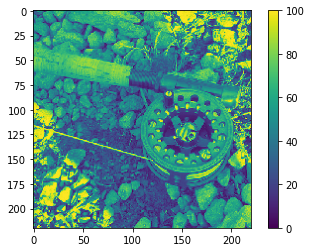

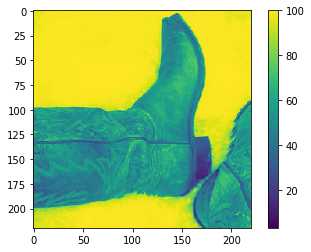

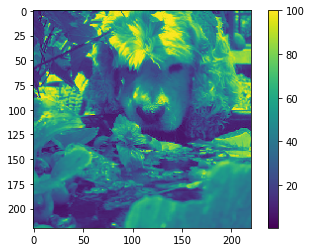

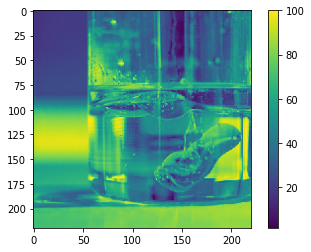

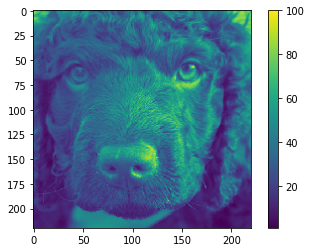

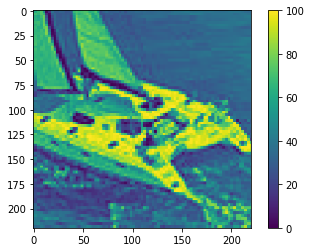

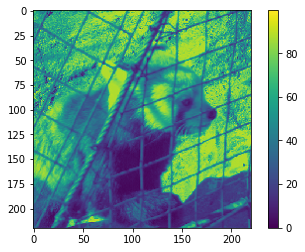

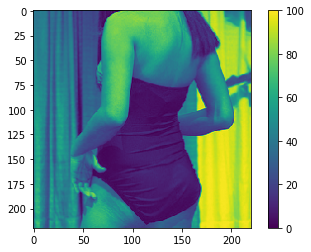

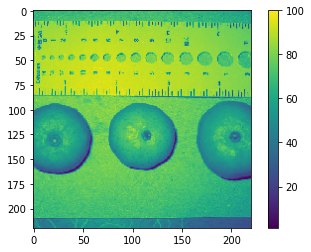

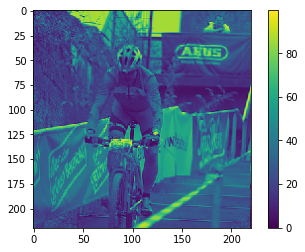

In [6]:
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# from PIL import Image

# # Ensure the Imagenet folder exists and set permissions
# imagenet_dir = '/CSNG/baroni/mozaik-models/Images/Imagenet'
# os.makedirs(imagenet_dir, exist_ok=True)
# os.chmod(imagenet_dir, 0o777)

# for i in range(10):
#     image = np.load(f'/CSNG/baroni/Dic23data/single_trial/000000000{i}/stimulus.npy') * 255
#     plt.imshow(image / 255)
#     plt.colorbar()
#     plt.show()
#     pil_image = Image.fromarray(image.astype(np.uint8))
#     pil_image.save(f'{imagenet_dir}/000000000{i}.png')

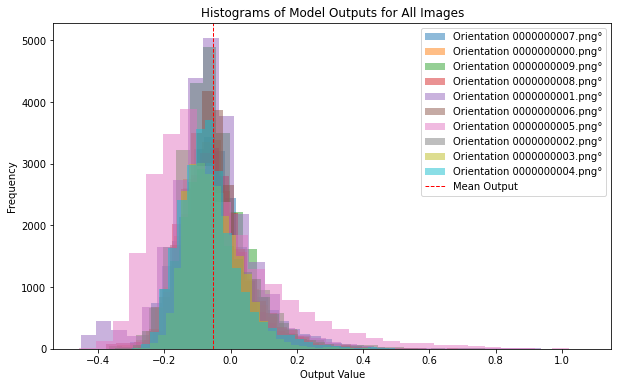

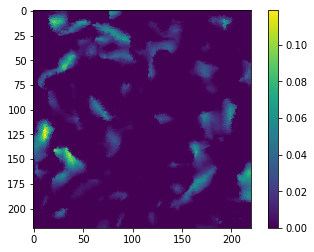

Saved 0000000007.npy in /CSNG/baroni/mozaik-models/Images_for_optostim/experiment_4/


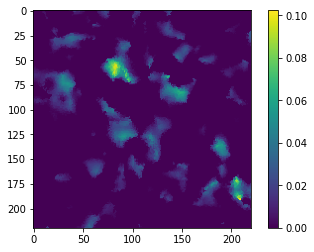

Saved 0000000000.npy in /CSNG/baroni/mozaik-models/Images_for_optostim/experiment_4/


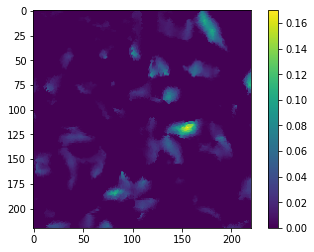

Saved 0000000009.npy in /CSNG/baroni/mozaik-models/Images_for_optostim/experiment_4/


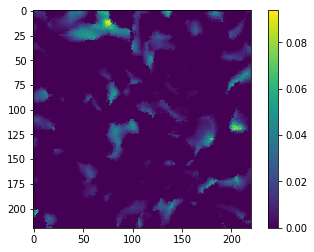

Saved 0000000008.npy in /CSNG/baroni/mozaik-models/Images_for_optostim/experiment_4/


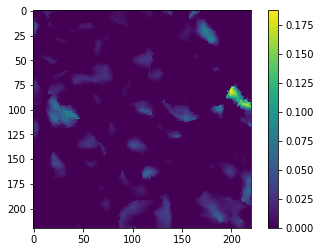

Saved 0000000001.npy in /CSNG/baroni/mozaik-models/Images_for_optostim/experiment_4/


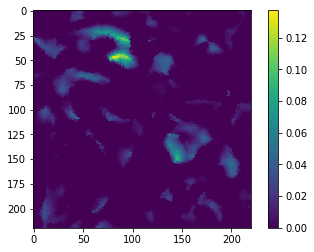

Saved 0000000006.npy in /CSNG/baroni/mozaik-models/Images_for_optostim/experiment_4/


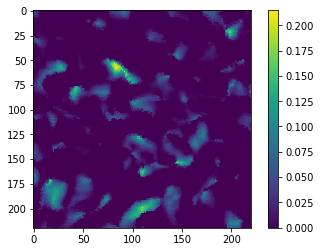

Saved 0000000005.npy in /CSNG/baroni/mozaik-models/Images_for_optostim/experiment_4/


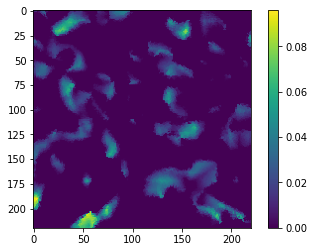

Saved 0000000002.npy in /CSNG/baroni/mozaik-models/Images_for_optostim/experiment_4/


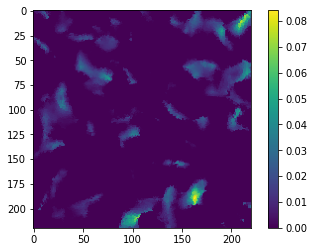

Saved 0000000003.npy in /CSNG/baroni/mozaik-models/Images_for_optostim/experiment_4/


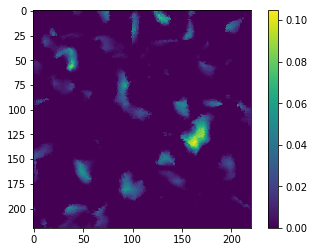

Saved 0000000004.npy in /CSNG/baroni/mozaik-models/Images_for_optostim/experiment_4/


In [8]:
from LSV1M_training.load_best_model import model
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import stat

# Directory and image settings
image_dir = '/CSNG/baroni/mozaik-models/Images/Imagenet'  # Directory containing input images
output_dir = '/CSNG/baroni/mozaik-models/Images_for_optostim/experiment_4/'  # Directory to save output images
max_value = 5  # Maximum value for image normalization
pixel_min = -1.8347  # Minimum pixel value for scaling
pixel_max = 2.1465  # Maximum pixel value for scaling

# Get all image paths in the directory
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.png')]

def create_images_for_optostim(model, image_paths, output_dir, max_value, pixel_min, pixel_max):
    """
    Processes a set of images through a trained model, generates model outputs for optostimulation.

    Parameters:
    - model: The trained model used for processing images.
    - image_paths: List of paths to the input images.
    - output_dir: Directory where the processed images will be saved.
    - max_value: Maximum value for normalizing the output images.
    - pixel_min: Minimum pixel value for scaling input images.
    - pixel_max: Maximum pixel value for scaling input images.

    This function performs the following steps:
    1. Loads and preprocesses each image.
    2. Passes the preprocessed image through the model to obtain outputs.
    3. Plots histograms of the model outputs for each image.
    4. Creates and saves images based on the model outputs.
    """
    # Check if GPU is available and set the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Image processing and model inference
    all_model_outputs = []
    for path in image_paths:
        image = Image.open(path).convert('L')  # Open image and convert to grayscale
        image = transforms.Resize((55, 55))(image)  # Resize image to 55x55
        image = (np.array(image) / 255.0) * (pixel_max - pixel_min) + pixel_min  # Scale image pixels
        image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # Convert to tensor
        model_output = model(image_tensor).detach().cpu().numpy().flatten()  # Get model output
        all_model_outputs.append(model_output)

    # Plotting histograms
    plt.figure(figsize=(10, 6))
    for i, model_output in enumerate(all_model_outputs):
        orientation = os.path.basename(image_paths[i]).split('/')[-1]  # Extract orientation from filename
        plt.hist(model_output, bins=30, alpha=0.5, label=f'Orientation {orientation}°')  # Plot histogram
    mean_output = np.concatenate(all_model_outputs).mean()  # Calculate mean of all outputs
    plt.axvline(mean_output, color='r', linestyle='dashed', linewidth=1, label='Mean Output')  # Plot mean line
    plt.title('Histograms of Model Outputs for All Images')
    plt.xlabel('Output Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Image creation and saving
    resp_dict = {p: resp for p, resp in zip(image_paths, all_model_outputs)}  # Map image paths to model outputs
    pos = model.readout['all_sessions'].mu.squeeze()[:, :2].cpu()  # Get model readout positions
    resolution = 220  # Resolution for output images
    x_min, x_max = pos[:, 1].min(), pos[:, 1].max()  # X-axis range
    y_min, y_max = pos[:, 0].min(), pos[:, 0].max()  # Y-axis range

    for p, resp in resp_dict.items():
        image = np.zeros((resolution, resolution))  # Initialize output image
        for i in range(resolution):
            for j in range(resolution):
                x_coord = -(x_min + (x_max - x_min) * j / (resolution - 1))  # Calculate x-coordinate
                y_coord = -(y_min + (y_max - y_min) * i / (resolution - 1))  # Calculate y-coordinate
                distances = np.sqrt((pos[:, 1] - x_coord)**2 + (pos[:, 0] - y_coord)**2)  # Calculate distances
                closest_point_idx = distances.argmin()  # Find closest point index
                image[i, j] = resp[closest_point_idx]  # Assign response value to image pixel
        
        image = np.flipud(image)  # Flip image vertically
        image = np.clip(image, 0, max_value) / max_value  # Normalize image
        plt.imshow(image)  # Display image
        plt.colorbar()  # Add colorbar
        plt.show()

        os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist
        os.chmod(output_dir, stat.S_IRWXU | stat.S_IRWXG | stat.S_IRWXO)  # Set directory permissions
        file_name = p.split('/')[-1].split('.')[0] + '.npy'  # Generate output filename
        np.save(os.path.join(output_dir, file_name), image)  # Save image as .npy file
        print(f"Saved {file_name} in {output_dir}")  # Print confirmation message

create_images_for_optostim(model, image_paths, output_dir, max_value, pixel_min, pixel_max)